# Desempenho CE-DDO-OFDM vs DDO-OFDM

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from optic.metrics     import fastBERcalc, signal_power
from optic.core        import parameters
from optic.models      import ssfm, photodiode

from tqdm.notebook     import tqdm
from utils.ofdm        import Tx, Rx, PAPR
from commpy.utilities  import upsample
from tqdm.notebook     import tqdm
from tabulate          import tabulate

pi = np.pi

In [2]:
import scienceplots

plt.style.use('science')
font = {'size':14}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 100

## Parametrização do sistema

In [29]:
# Parâmetros do transmissor
paramTx = parameters()

# OFDM
paramTx.M    = 16                        # Número de símbolos da constelação QAM
paramTx.Nfft = 512                      # Tamanho da FFT
paramTx.Ns = int(paramTx.Nfft/2) - 1    # Número de sub-portadoras
paramTx.N  = paramTx.Ns                 # Número de portadoras de informação
paramTx.Nz = paramTx.Ns - paramTx.N     # Número de subportadoras nulas
paramTx.G  = 4                          # Tamanho do prefixo cíclico
paramTx.K  = 4                          # Número de portadoras piloto por bloco OFDM

Rb          = 6e9                       # Taxa de bits/s
paramTx.Rs  = Rb*paramTx.Ns*(1 + paramTx.G/paramTx.Nfft) / (np.log2(paramTx.M)*paramTx.N)      # Banda do sinal
paramTx.SpS = 32                        # Amostras por símbolo
paramTx.Fa  = paramTx.Rs*paramTx.SpS    # Frequência de amostragem
paramTx.Fc  = 193.4e12                  # Frequência da portadora óptica
# Portadora elétrica
paramTx.fc = 1e9                         # Frequência da portadora [Hz]
# MZM e potência de entrada
paramTx.Vπ = 4
paramTx.Vb = -0.5*paramTx.Vπ

In [30]:
# Parâmetros da fibra
paramCh = parameters()

paramCh.Ltotal  = 100         # Comprimento total do link [km]
paramCh.Lspan   = 100         # Comprimento de um span de fibra [km]
paramCh.hz      = 1.0         # Comprimento do passo para o método SSF [km]
paramCh.alpha   = 0.2         # Atenuação da fibra [dB/km]
paramCh.D       = 16          # Parâmetro de dispersão cromática [ps/nm/km]
paramCh.gamma   = 1.3         # Parâmetro de não-linearidade da fibra [1/W/km]
paramCh.amp     = 'edfa'      # Tipo de amplificador
paramCh.NF      = 4.5         # Figura de ruído do amplificador [dB]
paramCh.Fc      = paramTx.Fc  # Frequência da portadora óptica [Hz]
paramCh.prgsBar = False

In [31]:
# Parâmetros do fotodetector
paramPD = parameters()

paramPD.R  = 1           # Responsividade
paramPD.Tc = 25          # Temperatura [°C]
paramPD.Id = 5e-9        # Corrente de escuro [A]
paramPD.RL = 50          # Resistência [Ω]
paramPD.B  = 2.5e9       # Largura de banda [Hz]
paramPD.Fa = paramTx.Fa  # Frequência de amostragem
paramPD.N  = 8001        # Tamanho do resposta do filtro
paramPD.ideal = False    # Definição do modelo: ideal ou real

In [32]:
# Parâmetros do receptor
paramRx = parameters()

paramRx.SpS = paramTx.SpS       # Amostras por símbolo
paramRx.Fa  = paramTx.Fa        # Frequência de amostragem
paramRx.fc  = paramTx.fc        # Frequência da portadora elétrica
paramRx.Nfft = paramTx.Nfft
paramRx.Ns = paramTx.Ns
paramRx.N  = paramTx.N
paramRx.Nz = paramTx.Nz
paramRx.G  = paramTx.G
paramRx.K  = paramTx.K

## 1 - Modulação 4-QAM

In [33]:
# Parametrização do sistema

table = [['Grandeza', 'Parâmetro', 'Valor'],
         ['Taxa de transmissão', 'Rb', f'{round(Rb*1e-9, 2)} Gb/s'], 
         ['Tamanho da FFT', 'Nfft', f'{paramTx.Nfft}'], 
         ['Tamanho da constelação', 'M', f'{paramTx.M}'], 
         ['Tamanho do prefixo cíclico', 'G', f'{paramTx.G}'], 
         ['Total de subportadoras', 'Ns', f'{paramTx.Ns}'], 
         ['Subportadoras de informação', 'N', f'{paramTx.N}'],
         ['Subportadoras anuladas', 'Nz', f'{paramTx.Nz}'],
         ['Subportadoras de informação', 'N', f'{paramTx.N}'],
         ['Largura de banda', 'Bw', f'{round(paramTx.Rs*1e-9, 2)} GHz'], 
         ['Espaçamento entre subportadoras', 'Delta_f', f'{ round((paramTx.Rs/paramTx.Nfft)*1e-6, 2)} MHz'],
         ['Duração do símbolo OFDM', 'Ts', f'{round((paramTx.Nfft/paramTx.Rs)*1e6,2)} us'],
         ['Duração do prefixo cíclico', 'Tg', f'{round((paramTx.G/paramTx.Rs)*1e9,2)} ns'],
         ['Frequência central', 'fc', f'{round((paramTx.fc)*1e-9,2)} GHz']]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════════════════════════════╤═════════════╤══════════╕
│ Grandeza                        │ Parâmetro   │ Valor    │
╞═════════════════════════════════╪═════════════╪══════════╡
│ Taxa de transmissão             │ Rb          │ 6.0 Gb/s │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho da FFT                  │ Nfft        │ 512      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho da constelação          │ M           │ 16       │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho do prefixo cíclico      │ G           │ 4        │
├─────────────────────────────────┼─────────────┼──────────┤
│ Total de subportadoras          │ Ns          │ 255      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Subportadoras de informação     │ N           │ 255      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Subportadoras anuladas          │ Nz          │ 0        │
├───────────────────────

In [39]:
# Sinal DDO-OFDM
paramTx.g = 0.55
paramTx.Scheme = "DDO-OFDM"

sigTxoDD, sigTxDD, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)
sigTxoDD = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxoDD/np.sqrt(signal_power(sigTxoDD))

In [40]:
# Sinal CE-DDO-OFDM
paramTx.A = 2
paramTx.H = 0.35/(2*pi)
paramTx.Scheme = "CE-DDO-OFDM"

sigTxoCE, sigTxCE, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)
sigTxoCE = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxoCE/np.sqrt(signal_power(sigTxoCE))

(-200, -87.0)

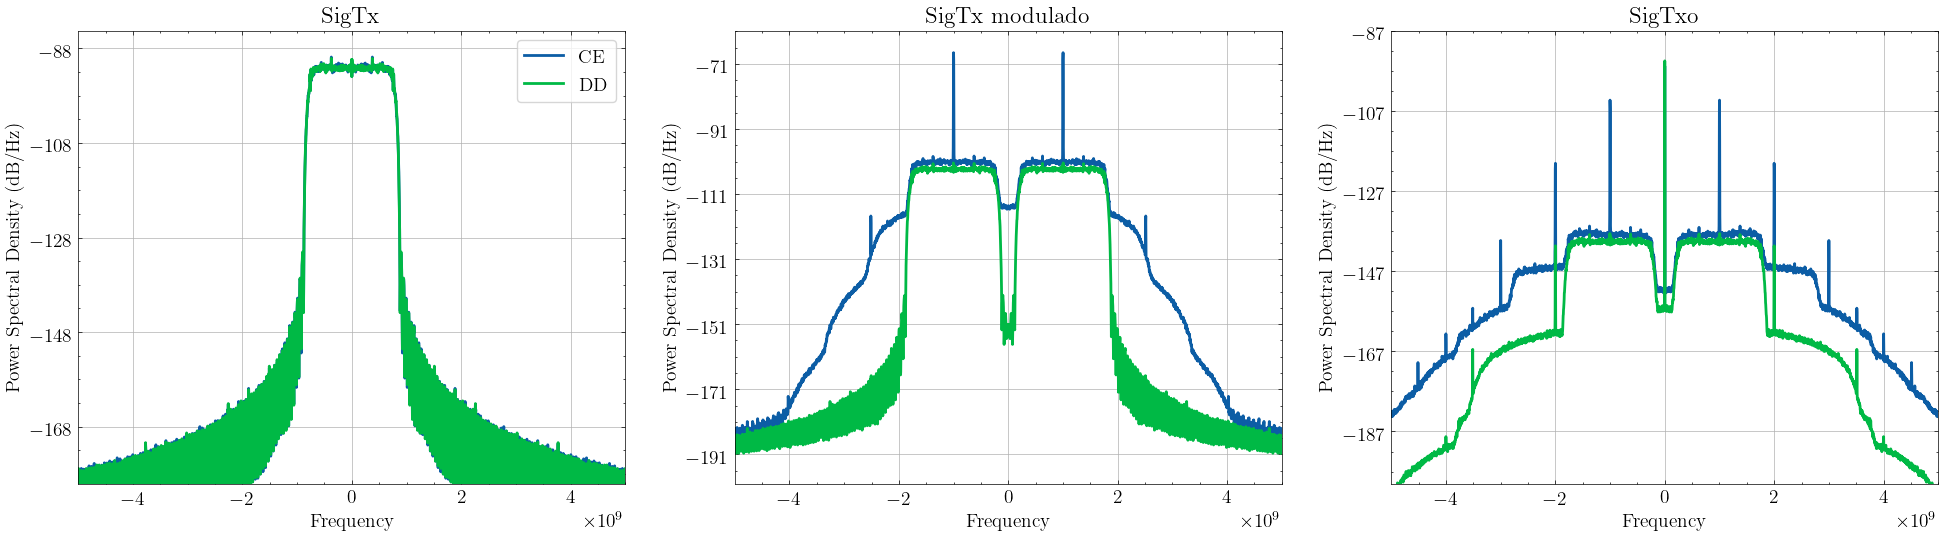

In [41]:
fig, ax = plt.subplots(1, 3, figsize = (24, 6))

ax[0].psd(sigTxCE, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'CE')
ax[0].psd(sigTxDD, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'DD')
ax[0].set_title('SigTx')
ax[0].legend(frameon = True)
ax[0].set_xlim(-5e9, 5e9)
ax[0].set_ylim(-180)

ax[1].psd(sigTx_CE, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'CE')
ax[1].psd(sigTx_DD, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'DD')
ax[1].set_title('SigTx modulado')
ax[1].set_xlim(-5e9, 5e9)
ax[1].set_ylim(-200)

ax[2].psd(sigTxoCE, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'CE')
ax[2].psd(sigTxoDD, Fs=paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = 'DD')
ax[2].set_title('SigTxo')
ax[2].set_xlim(-5e9, 5e9)
ax[2].set_ylim(-200)

In [42]:
# CE-DDO-OFDM
paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = "CE-DDO-OFDM"

Pi_dBm  = np.array([2, 4, 8, 10])
Ltotal  = np.arange(100, 1500, 100)

BER_CE_16QAM  = np.zeros((len(Pi_dBm), len(Ltotal)))

for i in tqdm(range(len(Pi_dBm))):
    paramTx.Pi_dBm = Pi_dBm[i]
    sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)
    sigRxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    
    for j in range(len(Ltotal)):
        sigRxo,_  = ssfm(sigRxo, paramTx.Fa, paramCh)
        ipd = photodiode(sigRxo, paramPD)
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        BER_CE_16QAM[i, j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/4 [00:00<?, ?it/s]

In [44]:
# DDO-OFDM
paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = "DDO-OFDM"

Pi_dBm  = np.array([2, 4, 8, 10])
Ltotal  = np.arange(100, 1500, 100)
BER_DD_16QAM  = np.zeros((len(Pi_dBm), len(Ltotal)))

for i in tqdm(range(len(Pi_dBm))):
    paramTx.Pi_dBm = Pi_dBm[i]
    sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)
    sigRxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    
    for j in range(len(Ltotal)):
        sigRxo,_  = ssfm(sigRxo, paramTx.Fa, paramCh)
        ipd = photodiode(sigRxo, paramPD)
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        BER_DD_16QAM[i, j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


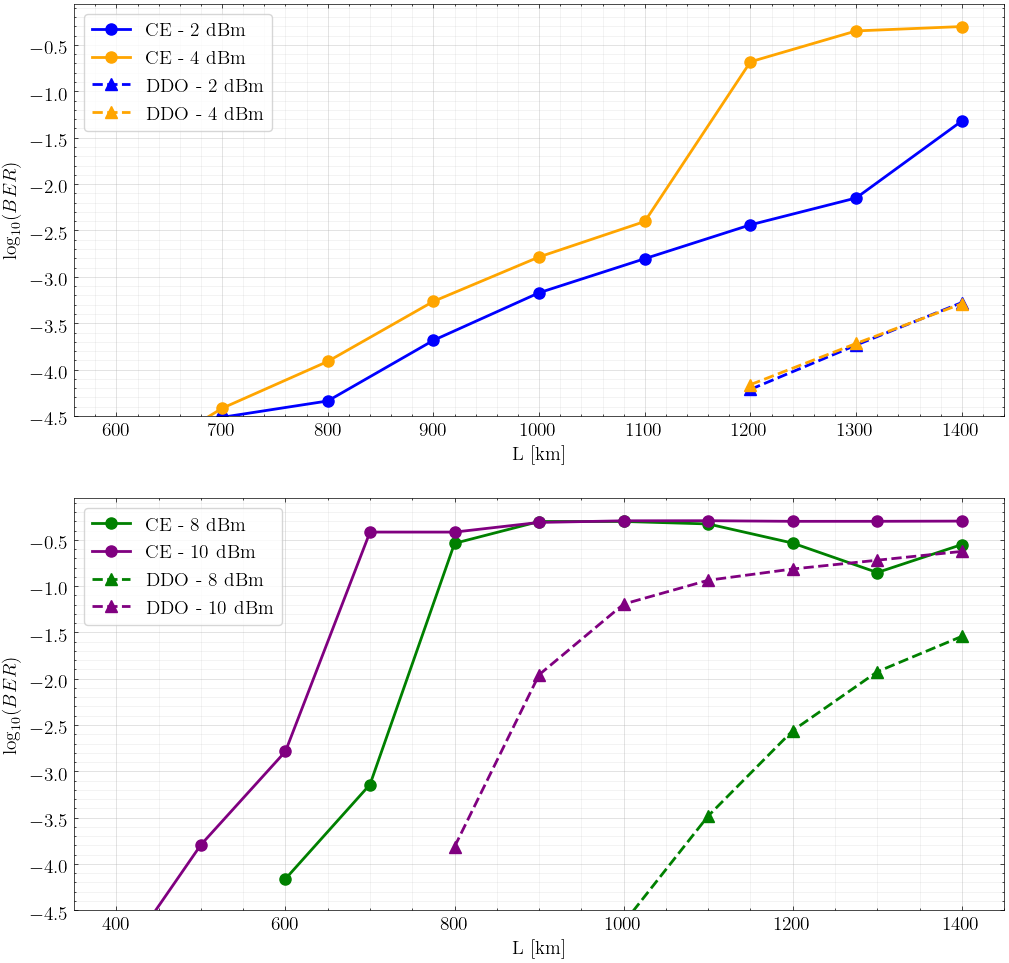

In [48]:
fig, axs = plt.subplots(2, 1, figsize = (12, 12))
color = ['blue', 'orange', 'green', 'purple']

for i in range(2):
    axs[0].plot(Ltotal, np.log10(BER_CE_16QAM[i,:]), '-o', color = color[i], ms = 8, lw = 2, label = f"CE - {Pi_dBm[i]} dBm")
    axs[0].plot(Ltotal, np.log10(BER_DD_16QAM[i,:]), '--^', color = color[i], ms = 8, lw = 2, label = f"DDO - {Pi_dBm[i]} dBm")
    
    axs[1].plot(Ltotal, np.log10(BER_CE_16QAM[i+2,:]), '-o', color = color[i+2], ms = 8, lw = 2, label = f"CE - {Pi_dBm[i+2]} dBm")
    axs[1].plot(Ltotal, np.log10(BER_DD_16QAM[i+2,:]), '--^', color = color[i+2], ms = 8, lw = 2, label = f"DDO - {Pi_dBm[i+2]} dBm")
    
axs[0].set_xlabel(r"L [km]")
axs[0].set_ylabel(r"$\log_{10}(BER)$")
axs[0].set_ylim(-4.5)
axs[0].grid(which='minor', alpha=0.2)
axs[0].grid(which='major', alpha=0.5)

handles,labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1], handles[3]]
labels = [labels[0], labels[2], labels[1], labels[3]]

axs[0].legend(handles, labels, frameon = True)

axs[1].set_xlabel(r"L [km]")
axs[1].set_ylabel(r"$\log_{10}(BER)$")
axs[1].set_ylim(-4.5)
axs[1].grid(which='minor', alpha=0.2)
axs[1].grid(which='major', alpha=0.5)

handles,labels = axs[1].get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1], handles[3]]
labels = [labels[0], labels[2], labels[1], labels[3]]

axs[1].legend(handles, labels, frameon = True)

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


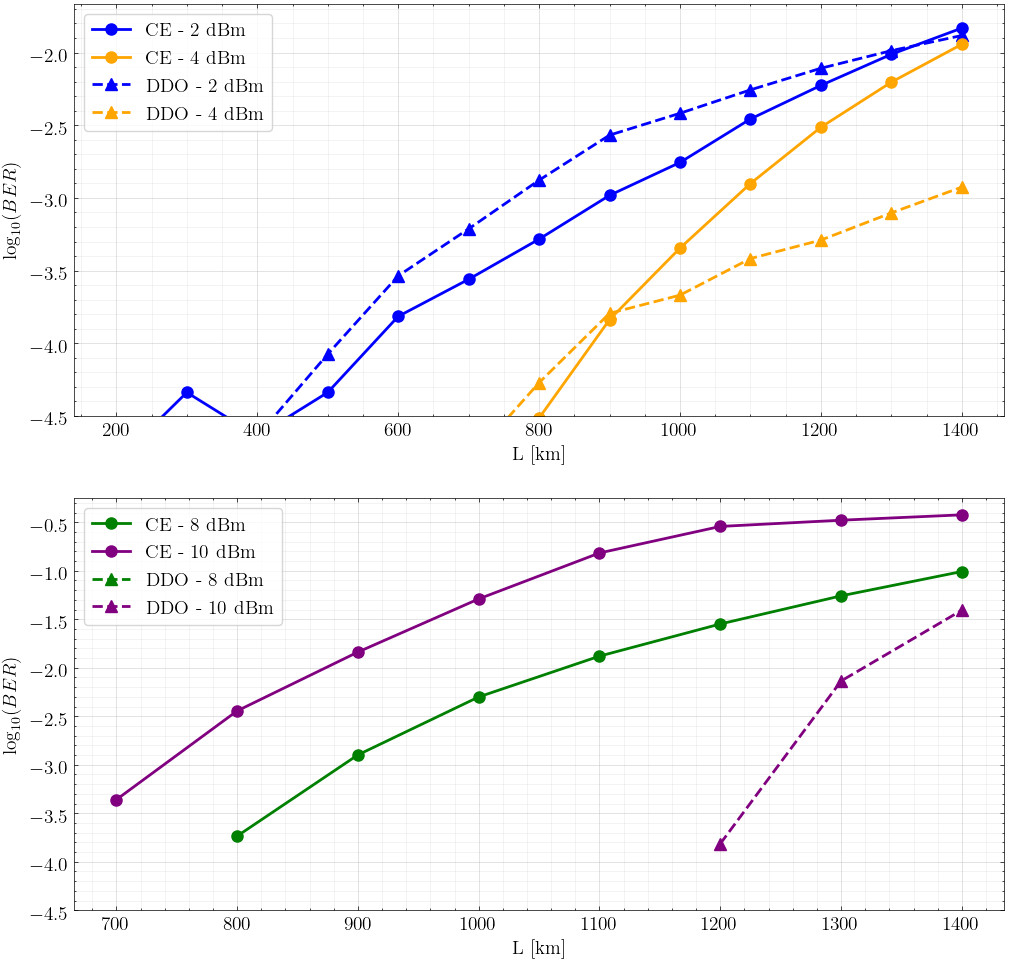

In [76]:
fig, axs = plt.subplots(2, 1, figsize = (12, 12))
color = ['blue', 'orange', 'green', 'purple']

for i in range(2):
    axs[0].plot(Ltotal, np.log10(BER_CE_16QAM[i,:]), '-o', color = color[i], ms = 8, lw = 2, label = f"CE - {Pi_dBm[i]} dBm")
    axs[0].plot(Ltotal, np.log10(BER_DD_16QAM[i,:]), '--^', color = color[i], ms = 8, lw = 2, label = f"DDO - {Pi_dBm[i]} dBm")
    
    axs[1].plot(Ltotal, np.log10(BER_CE_16QAM[i+2,:]), '-o', color = color[i+2], ms = 8, lw = 2, label = f"CE - {Pi_dBm[i+2]} dBm")
    axs[1].plot(Ltotal, np.log10(BER_DD_16QAM[i+2,:]), '--^', color = color[i+2], ms = 8, lw = 2, label = f"DDO - {Pi_dBm[i+2]} dBm")
    
axs[0].set_xlabel(r"L [km]")
axs[0].set_ylabel(r"$\log_{10}(BER)$")
axs[0].set_ylim(-4.5)
axs[0].grid(which='minor', alpha=0.2)
axs[0].grid(which='major', alpha=0.5)

handles,labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1], handles[3]]
labels = [labels[0], labels[2], labels[1], labels[3]]

axs[0].legend(handles, labels, frameon = True)

axs[1].set_xlabel(r"L [km]")
axs[1].set_ylabel(r"$\log_{10}(BER)$")
axs[1].set_ylim(-4.5)
axs[1].grid(which='minor', alpha=0.2)
axs[1].grid(which='major', alpha=0.5)

handles,labels = axs[1].get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1], handles[3]]
labels = [labels[0], labels[2], labels[1], labels[3]]

axs[1].legend(handles, labels, frameon = True)